In [1]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.2 MB/s eta 0:00:00


In [2]:
import os
import glob
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import math
from torchvision.utils import make_grid
from einops import rearrange
import functools
from tqdm.notebook import trange, tqdm

class catDogDataset(Dataset):
    def __init__(self, cat_directories, dog_directories, common_directories,
                 file_extensions=["*.jpg", "*.png", "*.jpeg"],
                 transform=None):
        self.files_and_labels = []
        self.cat_samples = 0 
        self.dog_samples = 0
        for ext in file_extensions:
            for directory in cat_directories:
                cat_files = glob.glob(os.path.join(directory, "**", ext), recursive=True)
                print(f"{len(cat_files)} {ext} cat images in {directory}")
                self.cat_samples += len(cat_files)
                cat_files = [[file, 0] for file in cat_files]
                self.files_and_labels.extend(cat_files)
            for directory in dog_directories:
                dog_files = glob.glob(os.path.join(directory, "**", ext), recursive=True)
                self.dog_samples += len(dog_files)
                print(f"{len(dog_files)} {ext} dog images in {directory}")
                dog_files = [[file, 1] for file in dog_files]
                self.files_and_labels.extend(dog_files)
            for directory in common_directories:
                dog_files = glob.glob(os.path.join(directory, "**", f"dog{ext}"), recursive=True)
                self.dog_samples += len(dog_files)
                print(f"{len(dog_files)} {ext} dog images in {directory}")
                dog_files = [[file, 1] for file in dog_files]
                self.files_and_labels.extend(dog_files)
                cat_files = glob.glob(os.path.join(directory, "**", f"cat{ext}"), recursive=True)
                self.cat_samples += len(cat_files)
                print(f"{len(cat_files)} {ext} cat images in {directory}")
                cat_files = [[file, 0] for file in cat_files]
                self.files_and_labels.extend(cat_files)
        weird_directory = '/kaggle/input/dog-face-recognition/train'
        dog_files = glob.glob(os.path.join(weird_directory, "**", "0001.jpg"), recursive=True)
        self.dog_samples += len(dog_files)
        print(f"{len(dog_files)} {ext} dog images in that weird directory")
        dog_files = [[file, 1] for file in dog_files]
        self.files_and_labels.extend(dog_files)
        self.transform = transform
    
    def __len__(self):
        return len(self.files_and_labels)

    def __getitem__(self, idx):
        file_path, label = self.files_and_labels[idx]
        try:
            image = Image.open(file_path)

            if image.mode == 'L':  # Check if the image is grayscale
                new_idx = (idx + 1) % len(self)
                return self.__getitem__(new_idx)

            image = image.convert('RGB')

            if self.transform:
                image = self.transform(image)
            return image, label
        
        except Exception as e:
            new_idx = (idx + 1) % len(self)
            return self.__getitem__(new_idx)
        

cat_directories = [
    '/kaggle/input/cat-face/data/cat_face',
    '/kaggle/input/cat-faces-data-set/Cat-faces-dataset-master',
    '/kaggle/input/afhq-512/cat',
    '/kaggle/input/cat-face-dataset',
    '/kaggle/input/cat-pattern-by-face/cat_face',
    '/kaggle/input/cat-dog/iopjqs1jr4f9py3o1r9478'
]

dog_directories = [
#     '/kaggle/input/dog-face-recognition',
    '/kaggle/input/dog-face-recognition/test_200_single_img',
    '/kaggle/input/dog-face-recognition/test_200_database',
    '/kaggle/input/cat-dog/93crsmi9z4e6klw0pvbzuv', # by https://images.cv/dataset/dog-face-image-classification-dataset
    '/kaggle/input/afhq-512/dog',
    '/kaggle/input/dog-face'
]

common_directories = ["/kaggle/input/cat-dog-64x64-pixel/CatDog"]

img_shape = (3, 48, 48)

augmentation = transforms.Compose([
    transforms.Resize(img_shape[1:]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), # seems like it also learns the rotation feature so minimize it
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomPerspective(p=0.35, distortion_scale=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = catDogDataset(cat_directories, dog_directories, common_directories, transform=augmentation)
print("Dataset size: ",len(dataset))
print("Dog images: ", dataset.dog_samples)
print("Cat images: ", dataset.cat_samples)

In [3]:
NEG_INFTY = -1e9

def scaled_dot_product(q, k, v):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

# provide some unique embedding data for each step
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
        
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
        self.act = nn.SiLU()
        self.dense2 = nn.Linear(output_dim, output_dim)
        
    def forward(self, x):
        x = self.dense(x)
        x = self.act(x)
        x = self.dense2(x)
        x = self.act(x)
        return x[..., None, None]

def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  

    Returns:
    The standard deviation.
    """    
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

# there are only 2 labels so text processing component is just embed layer of 2 keys
class ConditionEmbed(nn.Module):
    def __init__(self, label_size, embed_dim):
        super(ConditionEmbed, self).__init__()
        self.embed = nn.Embedding(label_size+1, embed_dim)

    def forward(self, ids):
        return self.embed(ids)
    
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x):
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scaled_dot_product(q, k, v)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)
        return out
    
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads, context_dim):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(context_dim, 2 * d_model)
        self.q_layer = nn.Linear(d_model, d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, y):
        # x is context (closer to encoder side) to attend to
        # y is the image value before cross attention
        batch_size, x_length, _ = x.size()
        _, y_length, d_model = y.size()
        kv = self.kv_layer(x)
        q = self.q_layer(y)
        kv = kv.reshape(batch_size, x_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, y_length, self.num_heads, self.head_dim)
        kv = kv.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        k, v = kv.chunk(2, dim=-1)
        values, attention = scaled_dot_product(q, k, v)
        values = values.permute(0,2,1,3).reshape(batch_size, y_length, d_model)
        out = self.linear_layer(values)
        return out

class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim=256, num_heads=4):
        super().__init__()
        self.self_attention = MultiHeadSelfAttention(hidden_dim, num_heads)
        self.cross_attention = MultiHeadCrossAttention(hidden_dim, num_heads, context_dim)
        self.ffn = nn.Sequential(nn.Linear(hidden_dim, hidden_dim*4, bias=False),
                                 nn.Linear(hidden_dim*4, hidden_dim, bias=False),
                                 nn.GELU())
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
    
    def forward(self, y, x):
        b, c, h, w = y.shape
        y = rearrange(y, "b c h w->b (h w) c")
        res_y = y.clone()
        y = self.self_attention(y)
        y = self.norm1(y + res_y)
        
        res_y = y.clone()
        y = self.cross_attention(x, y)
        y = self.norm1(y + res_y)
        
        res_y = y.clone()
        y = self.ffn(y)
        y = self.norm3(y + res_y)
        y = rearrange(y, 'b (h w) c -> b c h w', h=h, w=w)
        return y

In [4]:
class ResBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.layers = nn.Sequential(nn.Conv2d(channels_in, channels_out, 3, 
                                              stride=1, padding='same', padding_mode='reflect', 
                                              bias=False),
                                    nn.GroupNorm(4, num_channels=channels_out),
                                    nn.GELU(),
                                    nn.Conv2d(channels_out, channels_out, 3, 
                                              stride=1, padding='same', padding_mode='reflect', 
                                              bias=False),
                                    nn.GroupNorm(4, num_channels=channels_out))
    def forward(self, x):
        return nn.GELU()(self.layers(x) + x)
    
class DoubleConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.layers = nn.Sequential(nn.Conv2d(channels_in, channels_out, 3, 
                                              stride=1, padding='same', padding_mode='reflect', 
                                              bias=False),
                                    nn.GroupNorm(4, num_channels=channels_out),
                                    nn.GELU(),
                                    nn.Conv2d(channels_out, channels_out, 3, 
                                              stride=1, padding='same', padding_mode='reflect', 
                                              bias=False),
                                    nn.GroupNorm(4, num_channels=channels_out),
                                    nn.GELU())
    def forward(self, x):
        return self.layers(x)
    
class UnetDiffusion(nn.Module):
    def __init__(self, marginal_prob_std, 
                 channels=[32, 64, 128, 256, 512], 
                 embed_dim=256, 
                 text_dim=256, 
                 nClass=2):
        super().__init__()
        
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim)
            )
        # extract information
        self.conv = nn.Conv2d(3, channels[0], 3, stride=1, padding='same', padding_mode='reflect', bias=False)
        self.gnorm = nn.GroupNorm(4, num_channels=channels[0])
        self.conv_act = nn.GELU()
        self.resblock = ResBlock(channels[0], channels[0])
        self.dense = Dense(embed_dim, channels[0]) # 32 x 48 x 48
        
        self.down1 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1, padding_mode='reflect', bias=False)
        self.resblock1_1 = ResBlock(channels[1], channels[1])
        self.block1_1 = SpatialTransformer(channels[1], text_dim)
        self.dense1_1 = Dense(embed_dim, channels[1]) 
        self.resblock1_2 = ResBlock(channels[1], channels[1])
        self.dense1_2 = Dense(embed_dim, channels[1]) # 64 x 24 x 24
        
        self.down2 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1, padding_mode='reflect', bias=False)
        self.resblock2_1 = ResBlock(channels[2], channels[2])
        self.block2_1 = SpatialTransformer(channels[2], text_dim)
        self.dense2_1 = Dense(embed_dim, channels[2])
        self.resblock2_2 = ResBlock(channels[2], channels[2])
        self.dense2_2 = Dense(embed_dim, channels[2]) # 128 x 12 x 12

        self.down3 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1, padding_mode='reflect', bias=False)
        self.resblock3_1 = ResBlock(channels[3], channels[3])
        self.block3_1 = SpatialTransformer(channels[3], text_dim)
        self.dense3_1 = Dense(embed_dim, channels[3])
        self.resblock3_2 = ResBlock(channels[3], channels[3])
        self.dense3_2 = Dense(embed_dim, channels[3]) # 256 x 6 x 6
        
        self.down4 = nn.Conv2d(channels[3], channels[4], 3, stride=2, padding=1, padding_mode='reflect', bias=False)
        self.necknorm1 = nn.GroupNorm(4, num_channels=channels[4])
        self.neck1 = ResBlock(channels[4], channels[4]) 
        self.neck2 = ResBlock(channels[4], channels[4]) 
        self.neck3 = ResBlock(channels[4], channels[4]) # 512 x 3 x 3
        
        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[4], channels[3], 3, stride=2, padding=1, output_padding=1, bias=False) 
        self.block4_1 = SpatialTransformer(channels[4], text_dim)
        self.conv4 = DoubleConv(channels[4], channels[3])
        self.resblock4_1 = ResBlock(channels[3], channels[3])
        self.dense4_1 = Dense(embed_dim, channels[3])
        self.resblock4_2 = ResBlock(channels[3], channels[3])
        self.dense4_2 = Dense(embed_dim, channels[3]) # 256 x 6 X 6

        self.tconv5 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=1, bias=False) 
        self.block5_1 = SpatialTransformer(channels[3], text_dim)
        self.conv5 = DoubleConv(channels[3], channels[2])
        self.resblock5_1 = ResBlock(channels[2], channels[2])
        self.dense5_1 = Dense(embed_dim, channels[2])
        self.resblock5_2 = ResBlock(channels[2], channels[2])
        self.dense5_2 = Dense(embed_dim, channels[2]) # 128 x 12 X 12

        self.tconv6 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2,  padding=1, output_padding=1, bias=False) 
        self.block6_1 = SpatialTransformer(channels[2], text_dim)
        self.conv6 = DoubleConv(channels[2], channels[1])
        self.resblock6_1 = ResBlock(channels[1], channels[1])
        self.dense6_1 = Dense(embed_dim, channels[1]) 
        self.resblock6_2 = ResBlock(channels[1], channels[1])
        self.dense6_2 = Dense(embed_dim, channels[1]) # 64 x 24 x 24
        
        self.tconv7 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2,  padding=1, output_padding=1, bias=False) 
        self.conv7 = DoubleConv(channels[1], channels[0])
        self.resblock7_1 = ResBlock(channels[0], channels[0])
        self.dense7_1 = Dense(embed_dim, channels[0]) 
        self.resblock7_2 = ResBlock(channels[0], channels[0])
        self.dense7_2 = Dense(embed_dim, channels[0]) # 32 x 48 x 48
        
        self.res_final = ResBlock(channels[0], channels[0])
        self.conv_final = nn.Conv2d(channels[0], 3, 3, stride=1, padding=1, padding_mode='reflect', bias=False)
        # 3 x 64 x 64
        
        # The swish activation function
        self.act = nn.SiLU() # lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = ConditionEmbed(label_size=nClass, embed_dim=text_dim)
    
    def forward(self, x, t, y):
        # x is the input image
        # t is time step
        # y is the context text
        t_embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1) # 256
        
        # Encoding path
        
        # To get things started, convolution to get the number of channels to some what 32
        # Not an encoder but could be one for latent diffusion
        h1 = self.conv(x)
        h1 = self.conv_act(self.gnorm(h1))
        h1 = self.resblock(h1) + self.dense(t_embed)
        h1 = self.act(h1) # 32 x 48 x 48
        
        h2 = self.down1(h1) # 64 x 24 x 24
        h2 = self.resblock1_1(h2) + self.dense1_1(t_embed)
        h2 = self.block1_1(h2, y_embed)
        h2 = self.resblock1_2(h2) + self.dense1_2(t_embed)
        h2 = self.act(h2)
        
        # Attention thing started here, image was too big before this point
        h3 = self.down2(h2) # 128 x 12 x 12
        h3 = self.resblock2_1(h3) + self.dense2_1(t_embed)
        h3 = self.block2_1(h3, y_embed)
        h3 = self.resblock2_2(h3) + self.dense2_2(t_embed)
        h3 = self.act(h3)
        
        h4 = self.down3(h3) # 256 x 6 x 6
        h4 = self.resblock3_1(h4) + self.dense3_1(t_embed)
        h4 = self.block3_1(h4, y_embed)
        h4 = self.resblock3_2(h4) + self.dense3_2(t_embed)
        h4 = self.act(h4)
        
        # bottleneck
        h5 = self.down4(h4)
        h5 = self.conv_act(self.necknorm1(h5))
        h5 = self.neck1(h5) 
        h5 = self.neck2(h5) 
        h5 = self.neck3(h5) # 512 x 3 x 3
        
        h = self.tconv4(h5) 
        h = torch.cat((h, h4), dim=1) # 512 x 6 x 6
        h = self.block4_1(h, y_embed)
        h = self.conv4(h) # 256 x 6 x 6
        h = self.resblock4_1(h) + self.dense4_1(t_embed) 
        h = self.resblock4_2(h) + self.dense4_2(t_embed)
        h = self.act(h)
        
        h = self.tconv5(h) 
        h = torch.cat((h, h3), dim=1) # 256 x 12 x 12
        h = self.block5_1(h, y_embed)
        h = self.conv5(h) # 128 x 12 x 12
        h = self.resblock5_1(h) + self.dense5_1(t_embed)
        h = self.resblock5_2(h) + self.dense5_2(t_embed)
        h = self.act(h)
        
        h = self.tconv6(h) 
        h = torch.cat((h, h2), dim=1) # 128 x 24 x 24
        h = self.block6_1(h, y_embed)
        h = self.conv6(h) # 64 x 24 x 24
        h = self.resblock6_1(h) + self.dense6_1(t_embed)
        h = self.resblock6_2(h) + self.dense6_2(t_embed)
        h = self.act(h) 
        
        h = self.tconv7(h)
        h = torch.cat((h, h1), dim=1) # 64 x 48 x 48
        h = self.conv7(h) # 32 x 48 x 48
        h = self.resblock7_1(h) + self.dense7_1(t_embed)
        h = self.resblock7_2(h) + self.dense7_2(t_embed)
        h = self.act(h)
        
        h = self.res_final(h)
        h = self.conv_final(h) # 3 x 64 x 64
        
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [5]:
def get_device():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device = get_device()
num_steps = 300
eps = 1e-3
time_set = torch.linspace(1., eps, num_steps, device=device)
p_t = torch.ones(num_steps, device=device)
step_size = time_set[0] - time_set[1]

def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5, time_set=time_set):
    """The loss function for training score-based generative models.

    Args:
        model: A PyTorch model instance that represents a 
          time-dependent score-based model.
        x: A mini-batch of training data.    
        marginal_prob_std: A function that gives the standard deviation of 
          the perturbation kernel.
        eps: A tolerance value for numerical stability.
    """
#     t_indexes = p_t.multinomial(num_samples=x.shape[0], replacement=True)
#     random_t = time_set[t_indexes]
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t, y=y)
    # finding the noise that need to subtract from the output
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

In [6]:
label_map = {'cat': 0, 'dog': 1}

score_model = torch.nn.DataParallel(UnetDiffusion(marginal_prob_std=marginal_prob_std_fn))
# score_model = UnetDiffusion(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)

In [7]:
n_epochs = 30
batch_size = 64
lr = 1e-4

ckpt = torch.load('/kaggle/input/model-ckpt1/ckpt_transformer.pth',map_location=device)
score_model.load_state_dict(ckpt, strict=False) # architecture changes several time

optimizer = torch.optim.Adam(score_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.3, 0.95 ** epoch))
tqdm_epoch = trange(n_epochs)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
score_model.train()
best_loss = 253

for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, y in tqdm(data_loader):
        x = x.to(device)
        y = y.to(device)
        loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]
    avg_loss = avg_loss / num_items
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss, lr_current))
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(score_model.state_dict(), 'ckpt_transformer.pth')

<All keys matched successfully>

In [8]:
# param_size = 0
# for param in score_model.parameters():
#     param_size += param.nelement() * param.element_size()
# buffer_size = 0
# for buffer in score_model.buffers():
#     buffer_size += buffer.nelement() * buffer.element_size()

# size_all_mb = (param_size + buffer_size) / 1024**2
# print('model size: {:.3f}MB'.format(size_all_mb))

In [9]:
def Euler_Maruyama_sampler(score_model, 
              marginal_prob_std,
              diffusion_coeff, 
              batch_size=64, 
              x_shape=(3, 64, 64),
              num_steps=num_steps, 
              device='cuda', 
              eps=1e-3, y=None):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
            # Do not include any noise in the last sampling step.
    return mean_x

In [129]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

def reverse_standardization(standardized_tensor, mean=mean, std=std):
    # Ensure mean and std are broadcastable
    mean = mean.view(1, -1, 1, 1)
    std = std.view(1, -1, 1, 1)
    
    # Apply the inverse standardization
    original_tensor = standardized_tensor * std + mean
    return original_tensor

In [130]:
def bgr_to_rgb(bgr_tensor):
    # Rearrange the channel order: [B, G, R] to [R, G, B]
    rgb_tensor = bgr_tensor[:, [2, 1, 0], :, :]  # Swap B and R channels
    return rgb_tensor

/tmp/ipykernel_33/2070736080.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_33/2070736080.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


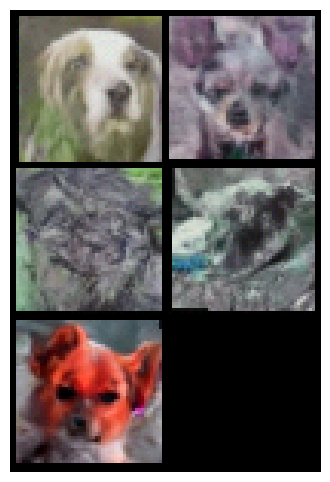

In [125]:
prompt = 'dog' 
label = label_map[prompt]
sample_batch_size = 5
num_steps = 300 
sampler = Euler_Maruyama_sampler 
img_shape = (3, 48, 48)

samples = sampler(score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size,
        x_shape=img_shape,
        num_steps=num_steps,
        device=device,
        y=(label*torch.ones(sample_batch_size, dtype=torch.long)).to(device))

proc = torch.clone(samples)
proc = reverse_standardization(proc)
proc = proc.clamp(0.0, 1.0)

sample_grid = make_grid(proc, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/tmp/ipykernel_33/2070736080.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_33/2070736080.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


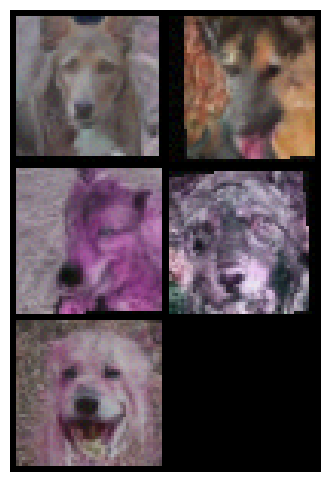

In [126]:
prompt = 'dog' 
label = label_map[prompt]
sample_batch_size = 5
num_steps = 300 
sampler = Euler_Maruyama_sampler 
img_shape = (3, 48, 48)

samples = sampler(score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size,
        x_shape=img_shape,
        num_steps=num_steps,
        device=device,
        y=(label*torch.ones(sample_batch_size, dtype=torch.long)).to(device))

proc = torch.clone(samples)
proc = reverse_standardization(proc)
proc = proc.clamp(0.0, 1.0)

sample_grid = make_grid(proc, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/tmp/ipykernel_33/2070736080.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_33/2070736080.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


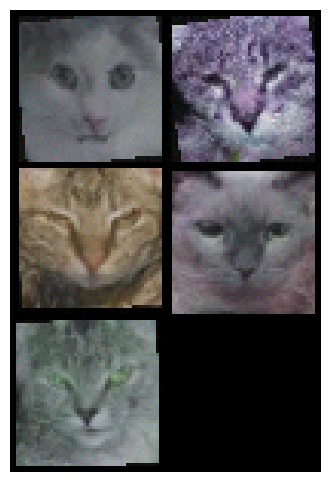

In [128]:
prompt = 'cat' 
label = label_map[prompt]
sample_batch_size = 5
num_steps = 300 

sampler = Euler_Maruyama_sampler 

samples = sampler(score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size, 
        x_shape=img_shape,
        num_steps=num_steps,
        device=device,
        y=(label*torch.ones(sample_batch_size, dtype=torch.long)).to(device))

proc = torch.clone(samples)
proc = reverse_standardization(proc)
proc = proc.clamp(0.0, 1.0)

sample_grid = make_grid(proc, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/tmp/ipykernel_33/2070736080.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_33/2070736080.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


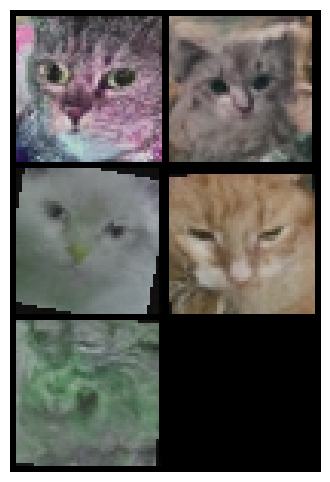

In [121]:
prompt = 'cat' 
label = label_map[prompt]
sample_batch_size = 5
num_steps = 500 

sampler = Euler_Maruyama_sampler 

samples = sampler(score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size, 
        x_shape=img_shape,
        num_steps=num_steps,
        device=device,
        y=(label*torch.ones(sample_batch_size, dtype=torch.long)).to(device))

proc = torch.clone(samples)
proc = reverse_standardization(proc)
proc = proc.clamp(0.0, 1.0)

sample_grid = make_grid(proc, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()